In [195]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm
# from tqdm.notebook import tqdm

from collections import OrderedDict, defaultdict
import itertools
from functools import partial
import datetime
from joblib import Parallel, delayed
import copy
import json

from data.dataloader import get_jhu_data, get_covid19india_api_data, get_rootnet_api_data
from data.processing import get_data, get_district_time_series, get_custom_data

from models.seir.seir_testing import SEIR_Testing
from main.seir.optimiser import Optimiser
from main.seir.losses import Loss_Calculator
from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, create_region_csv, create_all_csvs, write_csv, plot_forecast

## Load Covid19india Data

In [169]:
dataframes = get_covid19india_api_data()

In [170]:
predictions_dict = {}

In [190]:
get_custom_data('')

> /home/users/sansiddh/projects/covid/covid-modelling/data/processing.py(23)get_custom_data()
-> del df['Ward/block name']


(Pdb)  c


/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


> /home/users/sansiddh/projects/covid/covid-modelling/data/processing.py(37)get_custom_data()
-> df = df[['date', 'state', 'district', 'total_infected', 'hospitalised', 'recoveries', 'deceased']]


(Pdb)  c


,date,state,district,total_infected,hospitalised,recoveries,deceased
0,2020-04-19,Maharashtra,Pune,586,482,55,49
1,2020-04-20,Maharashtra,Pune,666,549,68,49
2,2020-04-21,Maharashtra,Pune,708,570,87,51
3,2020-04-22,Maharashtra,Pune,772,595,122,55
4,2020-04-23,Maharashtra,Pune,876,687,130,59
5,2020-04-24,Maharashtra,Pune,980,772,146,62
6,2020-04-25,Maharashtra,Pune,1070,845,159,66
7,2020-04-26,Maharashtra,Pune,1139,902,165,72
8,2020-04-27,Maharashtra,Pune,1217,966,176,75
9,2020-04-28,Maharashtra,Pune,1339,1057,203,79


## Select Districts to fit on

In [193]:
districts_to_show = [('Maharashtra', 'Pune'), 
                     ('Maharashtra', 'Mumbai'), 
                     ('Rajasthan', 'Jaipur'), 
                     ('Gujarat', 'Ahmedabad'), 
                     ('Karnataka', 'Bengaluru Urban'),
                     ('Delhi', None)]

districts_to_show = [('Maharashtra', 'Pune')]

## Perform M1 and M2 fits

fitting to data with "train_on_val" set to False ..


/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
           state district       date  hospitalised  total_infected  deceased  \
13  Maharashtra   Mumbai 2020-05-09       10530.0         12932.0     484.6   
14  Maharashtra   Mumbai 2020-05-10       11052.8         13642.6     508.6   
15  Maharashtra   Mumbai 2020-05-11       11611.0         14363.6     527.4   
16  Maharashtra   Mumbai 2020-05-12       12185.0         15138.4     553.8   
17  Maharashtra   Mumbai 2020-05-13       12726.6         15924.8     583.2   

    recovered  
13     1917.4  
14     2081.2  
15     2225.2  
16     2399.6  
17     2615.0  
val
          state district       date hospitalised total_infected deceased  \
0  Maharashtra   Mumbai 2020-05-14        13321        16731.6    616.8   
1  Maharashtra   Mumbai 2020-05-15        14129        17772.2    652.4   
2  Maharashtra   Mumbai 2020-05-16        14963        18889.8    692.6   
3  Maharashtra   Mumbai 2020-05-17        15657        19809.2    719.8   
4  Mah

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
           state district       date hospitalised total_infected deceased  \
20  Maharashtra   Mumbai 2020-05-16        14963        18889.8    692.6   
21  Maharashtra   Mumbai 2020-05-17        15657        19809.2    719.8   
22  Maharashtra   Mumbai 2020-05-18      16627.6        21098.6      757   
23  Maharashtra   Mumbai 2020-05-19        16848          21335      757   
24  Maharashtra   Mumbai 2020-05-20        18925          24118      841   

   recovered  
20    3234.2  
21    3432.4  
22      3714  
23      3730  
24      4352  
val
 None
100%|██████████| 700/700 [00:28<00:00, 24.92trial/s, best loss: 5.186750615828293] 
best parameters
 {'E_hosp_ratio': 0.36528317263295895, 'I_hosp_ratio': 0.319302903550854, 'P_fatal': 0.07215423899689016, 'P_severe': 0.8733363609292895, 'T_inc': 4.621590474438547, 'T_inf': 3.890170966341358, 'T_recov_severe': 59.903754508335744, 'lockdown_R0': 1.4641360217836012}


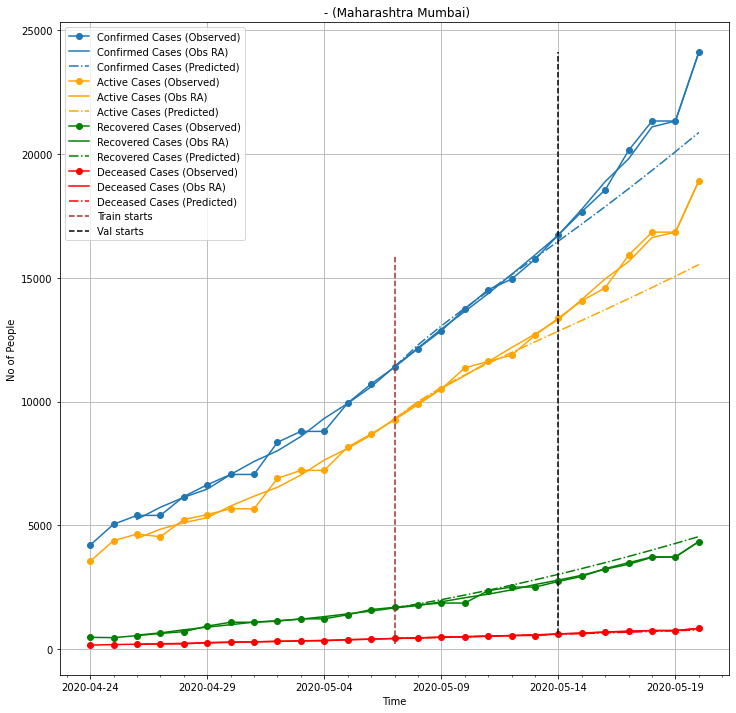

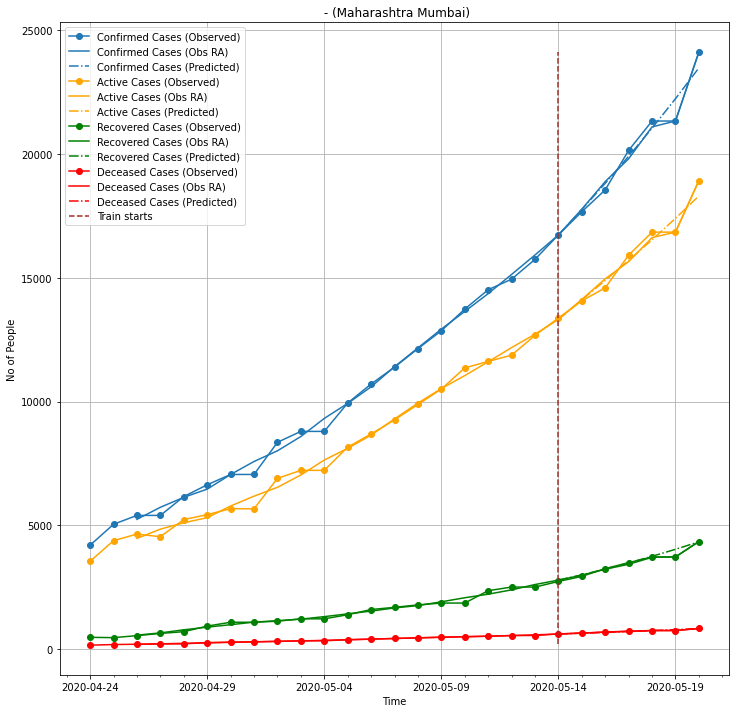

In [167]:
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=7, 
                                                                     data_from_tracker=True, initialisation='intermediate', num_evals=700,
                                                                     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=0, num_evals=700,
                                                                     train_on_val=True, data_from_tracker=True, initialisation='intermediate',
                                                                     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])

In [202]:
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=7, num_evals=1000,
                                                                     data_from_tracker=False, filename='../../data/data/official-pune-21-05-20.csv', 
                                                                     initialisation='intermediate',
                                                                     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=0, num_evals=1000,
                                                                     data_from_tracker=False, filename='../../data/data/official-pune-21-05-20.csv',
                                                                     initialisation='intermediate', train_on_val=True, 
                                                                     which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered'])

fitting to data with "train_on_val" set to False ..
splitting data ..
splitting data ..
train
          date        state district  total_infected  hospitalised  recovered  \
16 2020-05-07  Maharashtra     Pune          2148.6        1352.4      670.2   
17 2020-05-08  Maharashtra     Pune          2256.4        1356.6      767.2   
18 2020-05-09  Maharashtra     Pune          2365.2        1358.8      867.6   
19 2020-05-10  Maharashtra     Pune          2483.4        1363.2      975.2   
20 2020-05-11  Maharashtra     Pune          2599.2        1344.6     1104.2   

    deceased  
16     126.0  
17     132.6  
18     138.8  
19     145.0  
20     150.4  
val
         date        state district  total_infected  hospitalised  recovered  \
0 2020-05-12  Maharashtra     Pune          2720.6        1328.2     1236.2   
1 2020-05-13  Maharashtra     Pune          2842.8        1322.4     1358.2   
2 2020-05-14  Maharashtra     Pune          2987.2        1337.8     1480.0   
3 2020-05-15 

KeyboardInterrupt: 

In [175]:
predictions_dict[('Maharashtra', 'Mumbai')]['m1'].keys()

dict_keys(['best_params', 'default_params', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'ax', 'trials'])

## Create Master Loss Dataframe

### M1 Loss

In [138]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m1']['df_loss'].columns, predictions_dict[starting_key]['m1']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m1']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                    \
                            hospitalised total_infected deceased recovered   
Maharashtra Mumbai                  2.07           1.13     1.93      6.38   
            Pune                   11.79           7.67     1.61      5.04   
Rajasthan   Jaipur                  6.42           0.91     4.26      4.91   
Gujarat     Ahmedabad               0.97           0.56     2.73      2.13   
Karnataka   Bengaluru Urban         3.19           1.49        0       2.3   
Delhi       NaN                     1.75           1.23      1.7      4.15   

                                     val                                    
                            hospitalised total_infected deceased recovered  
Maharashtra Mumbai                  1.28           1.92     2.11      7.77  
            Pune                    3.18           0.95     12.1      6.11  
Rajasthan   Jaipur                 26.94            6.1    19.99     16.31  
Gujarat     Ahmedabad               6.12           3.22    12.96      5.52  
Karnataka   Bengaluru Urban         3.93           3.17     3.57      4.12  
Delhi       NaN                    11.66           5.84    34.15      9.35

### M2 Loss

In [44]:
starting_key = list(predictions_dict.keys())[0]

loss_columns = pd.MultiIndex.from_product([predictions_dict[starting_key]['m2']['df_loss'].columns, predictions_dict[starting_key]['m2']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m2']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                                  
                   hospitalised total_infected deceased recovered
Maharashtra Mumbai         2.07           1.05     0.73      9.54

## Plot Forecasts

getting forecasts ..
getting forecasts ..


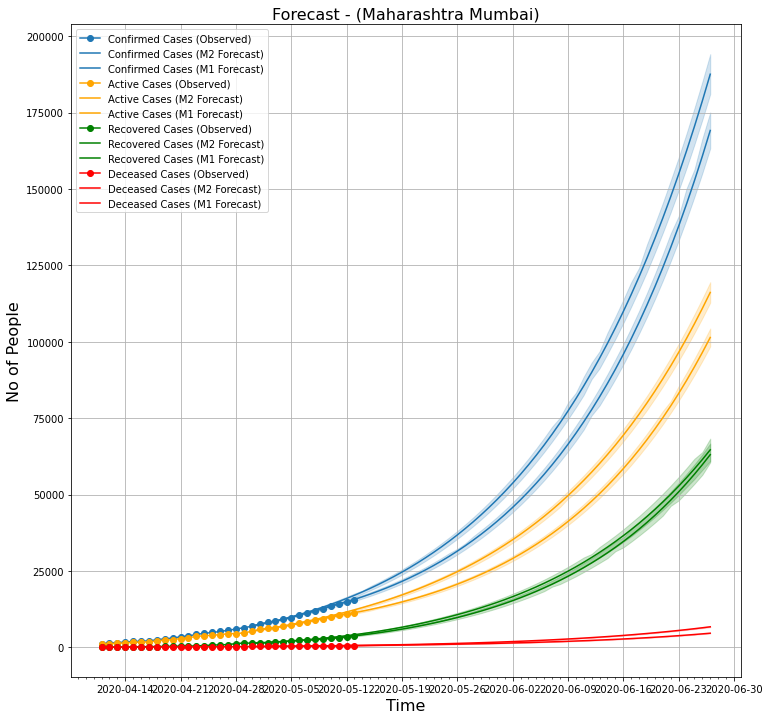

In [184]:
for region in predictions_dict.keys():
    plot_forecast(predictions_dict[region], region, both_forecasts=False, error_bars=False,)

## Create and Save Output CSV

In [85]:
df_output = create_all_csvs(predictions_dict, initialisation='intermediate', train_period=7, icu_fraction=0.02)

compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..


In [88]:
write_csv(df_output, '../../output-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))